# Project_5

### Importing libraries

Importing all the libraries I need.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [ ]:
import re
import string,time
from string import punctuation
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Reading, exploring dataset

#### Reading dataset

In [ ]:
data=pd.read_csv('LargeMovieReviewDataset.csv')
data.shape

(50000, 2)

From here I can see that there are 50000 rows and 2 columns in the dataset.

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Exploring dataset

Now I will explore the dataset, null values, basic statistics.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
null_values = data.isnull().sum() #identifying missing values
null_values

review       0
sentiment    0
dtype: int64

From here, I can see that there is no null value and that both features are object type.

In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Now I'll check for duplicates.

In [ ]:
data=data.drop_duplicates().reset_index(drop=True)
data.shape

(49582, 2)

In [ ]:
print('The dataset contains {} rows and {} columns after removing duplicates.'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates.


###### Exploring the target column

Now I will investigate the target column, how many values there are depending on the positive and negative classes.

In [ ]:
sentiment = data.sentiment

Now I will encode the sentiment column by using Lable encoder.

In [ ]:
data['sentiment'] = LabelEncoder().fit_transform(data.sentiment)

In [ ]:
sentiment.value_counts()/sentiment.shape *100

positive    50.187568
negative    49.812432
Name: sentiment, dtype: float64

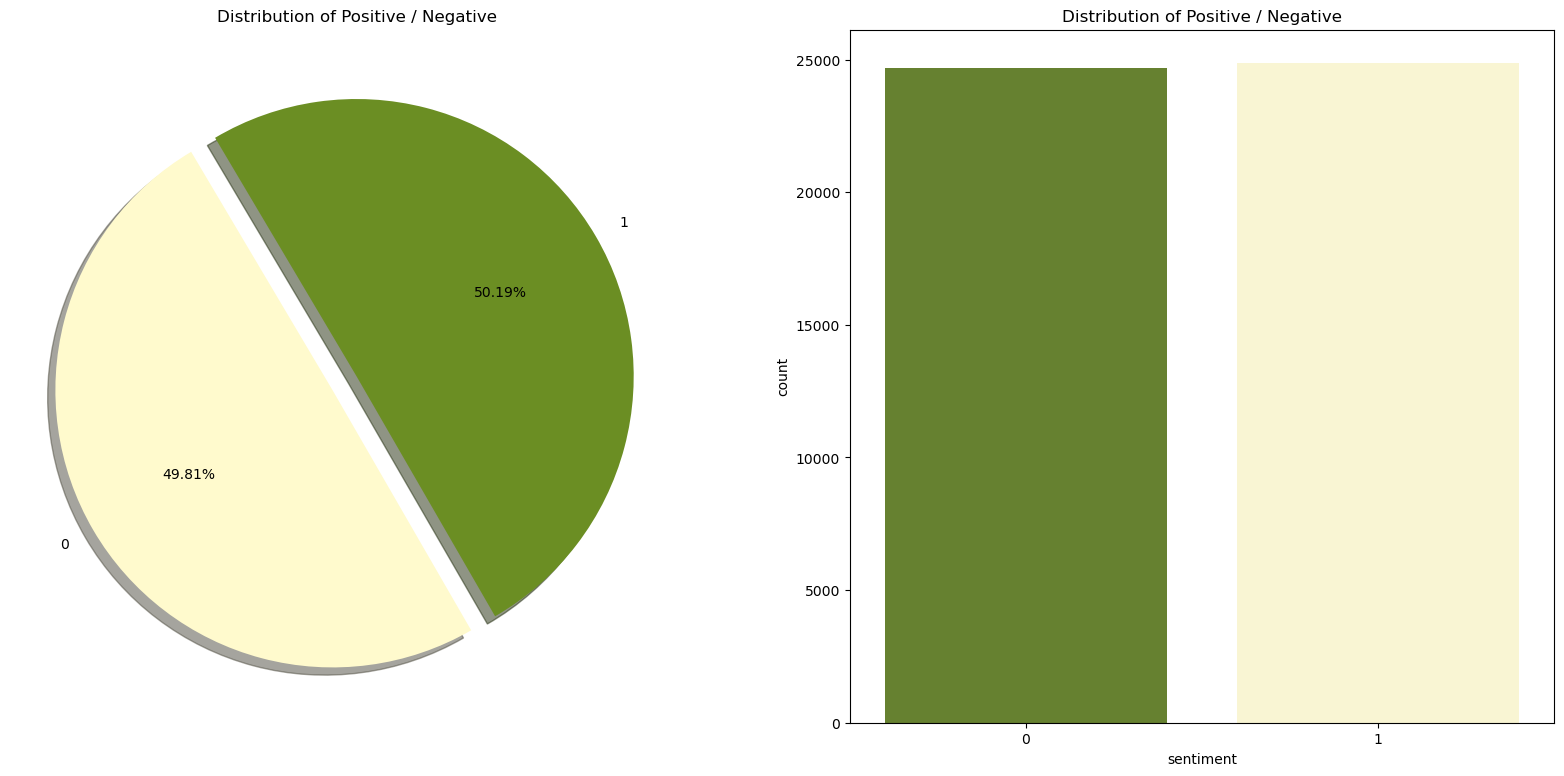

In [ ]:
a , ax = plt.subplots(1,2,figsize=(20,9))
data['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300, colors = ['olivedrab','lemonchiffon'])
ax[0].set_title('Distribution of Positive / Negative')
ax[0].set_ylabel('')
sns.countplot('sentiment', data = data ,ax=ax[1], palette=['olivedrab','lemonchiffon'])
ax[1].set_title('Distribution of Positive / Negative')
plt.show()

In [ ]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


In [ ]:
data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Since I already can see based on the review value of the first example that there are impurities in the data, I will use some methods to delete and organize the text.

### Text preprocessing

#### Cleaning

Now I will clean the text, delete htmls tags, urls, punctuation; convert short words into full words; convert uppercase letters to lowercase that the text can be used for further work.

In [ ]:
#remove html tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [ ]:
data['review'] = data['review'].apply(remove_html_tags)

In [ ]:
#remove urls
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [ ]:
data['review'] = data['review'].apply(remove_url)

In [ ]:
#putting space after comma
def SpaceAfterComma(text):
    s = re.sub(r'(?<=[.,])(?=[^\s])', r' ', text)
    return s

In [ ]:
data['review'] = data['review'].apply(SpaceAfterComma)

Creating a space after each comma and dot. The reason for this is that if I do not delete it, the word before and after the comma would be one word.

In [ ]:
def OneSpace(text):
    os=re.sub(' +', ' ', text)
    return os

In [ ]:
data['review'] = data['review'].apply(OneSpace)

In [ ]:
data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many. . Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more. . . . so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
exclude = string.punctuation

In [ ]:
#remove punctuation
def remove_punc(text):
    for char in exclude:
        text = text.replace(char,'')
    return text

In [ ]:
data['review'] = data['review'].apply(remove_punc)

In [ ]:
mapping = {"ain't": "is not","isnt":"is not", "arent":"are not", "aren't": "are not","can't": "cannot", "cant": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not","couldnt": "could not" ,
           "didn't": "did not","didnt": "did not",  "doesn't": "does not","doesnt": "does not","don't": "do not", "dont": "do not","hadn't": "had not",
           "hasn't": "has not", "hasnt": "has not", "haven't": "have not", "havnt": "have not","he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "Im": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [ ]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [ ]:
def preprocess(text):
    text=clean_contractions(text,mapping)
    return text

In [ ]:
data["review"] = data["review"].apply(lambda text: preprocess(text))
data['review'][0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many  Aryans Muslims gangstas Latinos Christians Italians Irish and more    so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pret

In [ ]:
#converting to lower letters
data['review'] = data['review'].str.lower()

In [ ]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
stopwords = stopwords.words('english')
# Creating a function to remove stopwords
def remove_stopwords(text):
    s = []
    for words in text.split():
        if words not in stopwords:
            s.append(words)
    a = s[:]
    s.clear()
    return ' '.join(a)

In [ ]:
# Applying that function in review feature to remove stopwords
data['review']=data['review'].apply(remove_stopwords)

#### Tokenization

Tokenization is the step by which the character string in a text segment is turned into units - tokens - for further analysis.

In [ ]:
def tokenization(text):
    return word_tokenize(text)

In [ ]:
data['tokens'] = data['review'].apply(tokenization)

In [ ]:
data

,review,sentiment,tokens
0,one reviewers mentioned watching 1 oz episode ...,1,"[one, reviewers, mentioned, watching, 1, oz, e..."
1,wonderful little production filming technique ...,1,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,1,"[thought, wonderful, way, spend, time, hot, su..."
3,basically theres family little boy jake thinks...,0,"[basically, theres, family, little, boy, jake,..."
4,petter matteis love time money visually stunni...,1,"[petter, matteis, love, time, money, visually,..."
...,...,...,...
49577,thought movie right good job wasnt creative or...,1,"[thought, movie, right, good, job, wasnt, crea..."
49578,bad plot bad dialogue bad acting idiotic direc...,0,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49579,catholic taught parochial elementary schools n...,0,"[catholic, taught, parochial, elementary, scho..."
49580,going disagree previous comment side maltin on...,0,"[going, disagree, previous, comment, side, mal..."


### Normalization

- Lemmatization - is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatization(text):
    lemmatized_sentence = " ".join(lemmatizer.lemmatize(token) for token in text)
    return lemmatized_sentence

In [ ]:
%%time
data["lemmatizer_review"] = data['tokens'].apply(lemmatization)

Wall time: 41 s


- Stemming -  is the process of reducing a word to its stem that affixes to suffixes and prefixes or to the roots of words known as "lemmas". Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

In [ ]:
#Stemming the text

ps = nltk.porter.PorterStemmer()


def stemmer(text):
    text = ' '.join([ps.stem(token) for token in text])
    return text

In [ ]:
%%time
data['stemmer_review'] = data['tokens'].apply(stemmer)

Wall time: 3min 7s


In [ ]:
data.head()

,review,sentiment,tokens,lemmatizer_review,stemmer_review
0,one reviewers mentioned watching 1 oz episode ...,1,"[one, reviewers, mentioned, watching, 1, oz, e...",one reviewer mentioned watching 1 oz episode y...,one review mention watch 1 oz episod youll hoo...
1,wonderful little production filming technique ...,1,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,thought wonderful way spend time hot summer we...,1,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...,thought wonder way spend time hot summer weeke...
3,basically theres family little boy jake thinks...,0,"[basically, theres, family, little, boy, jake,...",basically there family little boy jake think t...,basic there famili littl boy jake think there ...
4,petter matteis love time money visually stunni...,1,"[petter, matteis, love, time, money, visually,...",petter matteis love time money visually stunni...,petter mattei love time money visual stun film...


Stemming and Lemmatization both generate the root form of the inflected words. Lemmatization is the algorithmic process for finding the lemma of a word – it means unlike stemming which may result in incorrect word reduction, Lemmatization always reduces a word depending on its meaning. Considering that and the execution time, I will use lemmatization as a normalization technique.

In [ ]:
data["review"] = data["lemmatizer_review"]

In [ ]:
data = data.drop(["lemmatizer_review", "stemmer_review"], axis=1)

### Words importance

Now, I will make pos and neg lists. These are the lists of words found in the review column that belong to the positive (pos) or negative class (neg). I will use that to find 50 common words for each example of the positive class. Then I will repeat it for examples of the negative class.

In [ ]:
#positive reviews
df_pos = data.loc[data['sentiment'] == 1]
pos = ' '.join(df_pos.review).split()
#negative reviews
df_neg = data.loc[data['sentiment'] == 0]
neg = ' '.join(df_neg.review).split()

In [ ]:
#get most common 50 term's counts into a dataframe
pos_term_freq = pd.DataFrame(Counter(pos).most_common(50), columns=['term', 'count'])

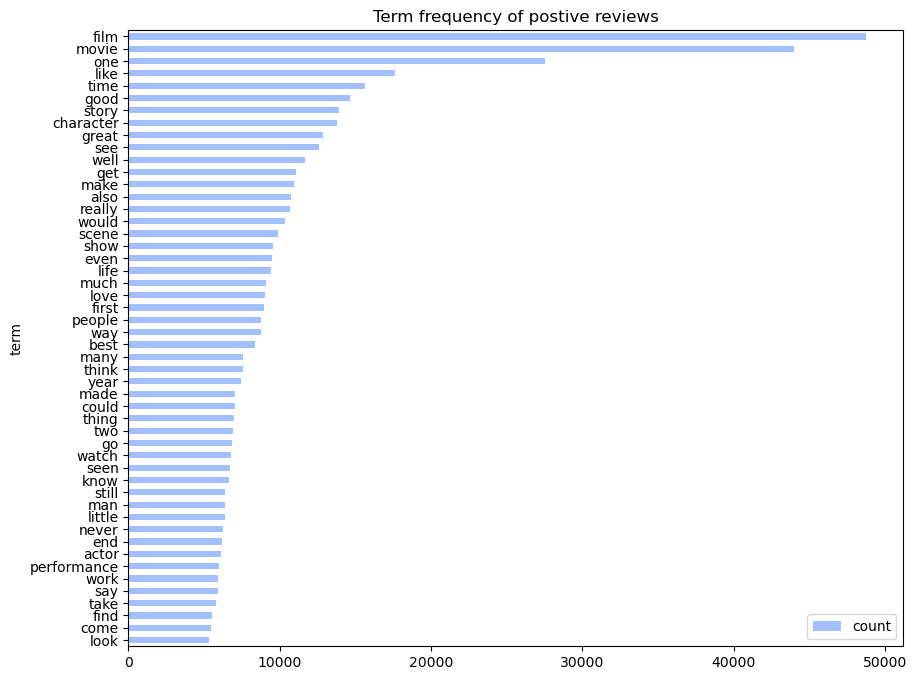

In [ ]:
#plot postive term frequencies
fig, ax = plt.subplots(figsize=(10, 8))
pos_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color='xkcd:pastel blue')
ax.set_title("Term frequency of postive reviews")
plt.show()

In [ ]:
#get most common 50 term's counts into a dataframe
neg_term_freq = pd.DataFrame(Counter(neg).most_common(50), columns=['term', 'count'])

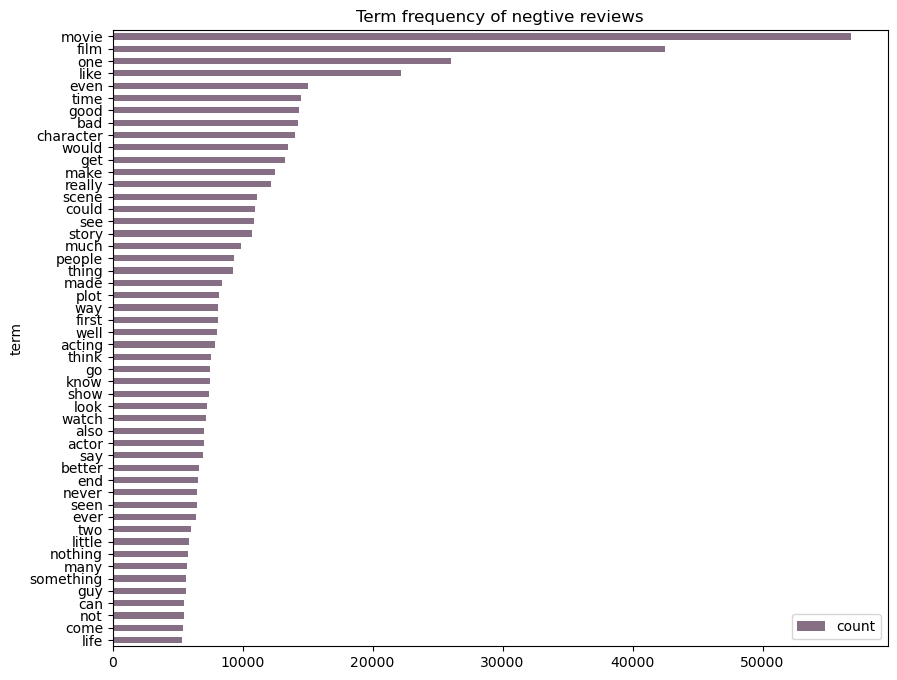

In [ ]:
#plot negative term frequencies
fig, ax = plt.subplots(figsize=(10, 8))
neg_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color='xkcd:purple grey')
ax.set_title("Term frequency of negtive reviews")
plt.show()


From here I can see that there are words on these two plots that are the same for both plots. I will make intersection for those two sets (pos i neg sets of words), and exclude those words that are repeated many times and are in both sets of words. After that, I will make a visualization of those sets without those most frequent common words.

In [ ]:
neg_term_freq_list = list(neg_term_freq["term"])
pos_term_freq_list = list(pos_term_freq["term"])
intersection = list(set(neg_term_freq_list) & set(pos_term_freq_list))
stopwords.extend(intersection)

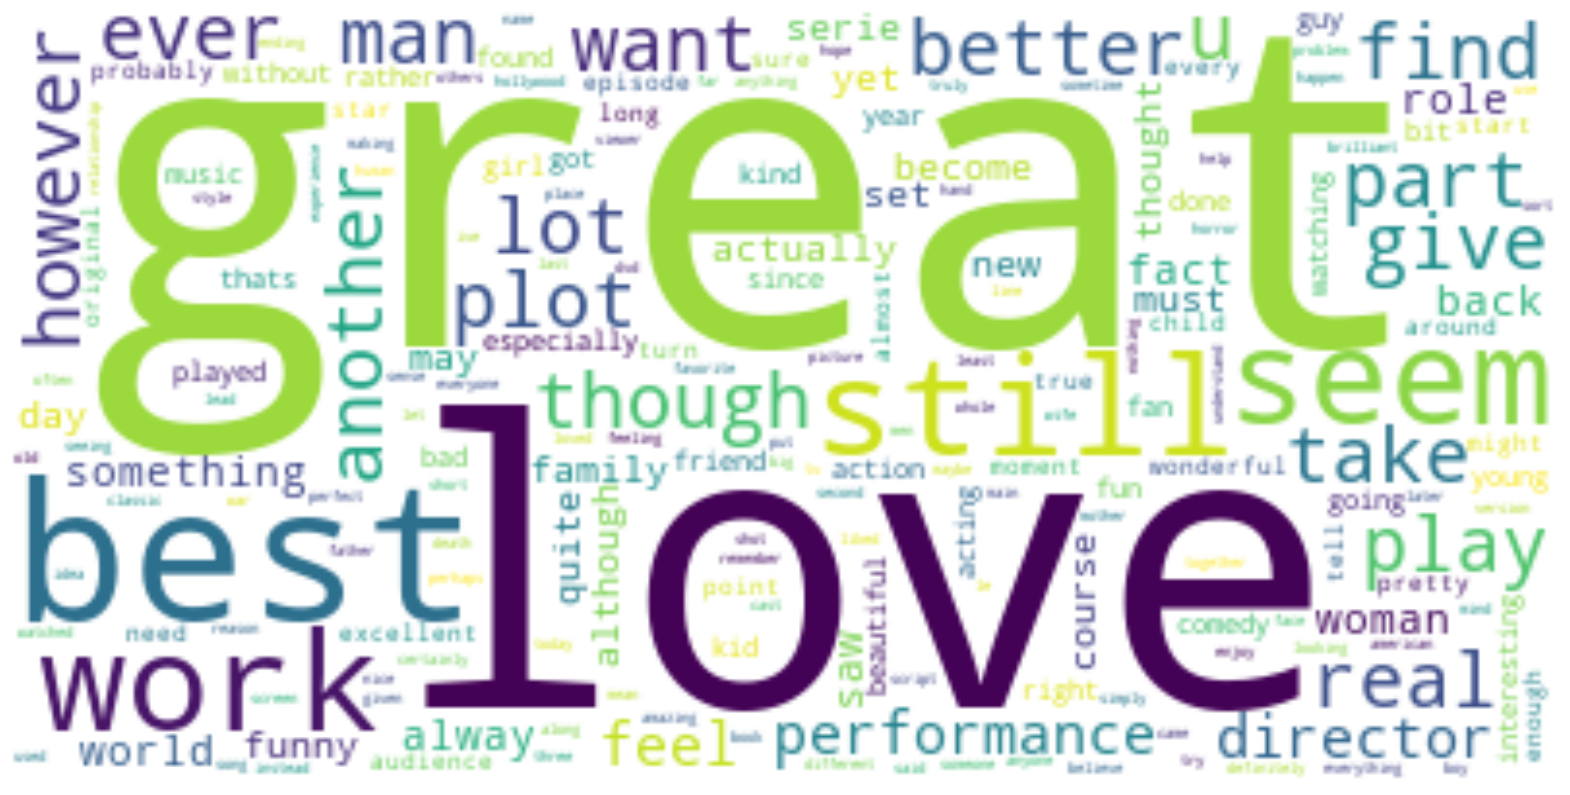

In [ ]:
#visualisation of positive sentiments
text_positive= " ".join(i for i in data[data["sentiment"] == 1].review)
stopwords = set(stopwords)
wordcloud_positive = WordCloud(stopwords=stopwords, background_color="white").generate(text_positive)
plt.figure( figsize=(20,15))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

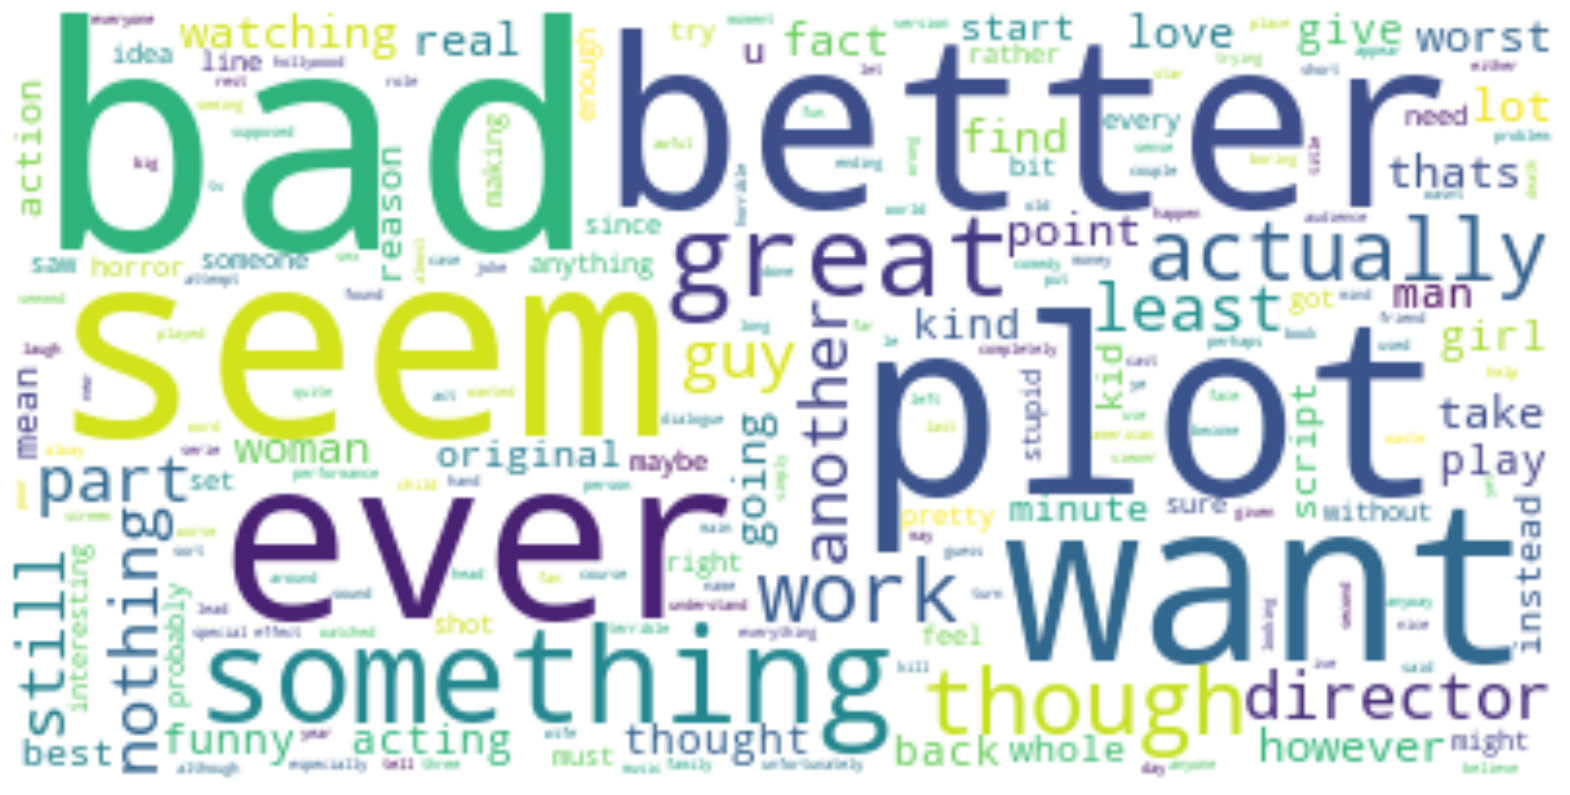

In [ ]:
#visualisation of negative sentiments
text_negative= " ".join(i for i in data[data["sentiment"] == 0].review)
stopwords = set(stopwords)
wordcloud_negative= WordCloud(stopwords=stopwords, background_color="white").generate(text_negative)
plt.figure( figsize=(20,15))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vectorization

In Machine Learning, vectorization is a step in feature extraction. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors. I decided to use the tfidf. After that i will split data in test and training.

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
text_count_matrix = tfidf.fit_transform(data.review)

In [ ]:
#splitting the complete dataset in test and training:
X_train, X_test, y_train, y_test = train_test_split(text_count_matrix, data.sentiment, test_size=0.20, random_state=2)

Now, I will calculate the accuracy, metrics and plot the confusion matrix for each model to see the performance of each model and compare them later.

In [ ]:
def metric_calculation(model):
    model.fit(X_train, y_train)
    # Evaluating the model
    accuracy_score = metrics.accuracy_score(model.predict(X_test), y_test)
    print(str('{:04.2f}'.format(accuracy_score*100))+" %")
    print("Classification Report: \n", classification_report(y_test, model.predict(X_test),target_names=['Negative','Positive']))
    metrics.plot_confusion_matrix(model, X_test, y_test,cmap = 'YlGnBu')
    plt.grid(False)
    return accuracy_score

88.93 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      4934
    Positive       0.89      0.90      0.89      4983

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



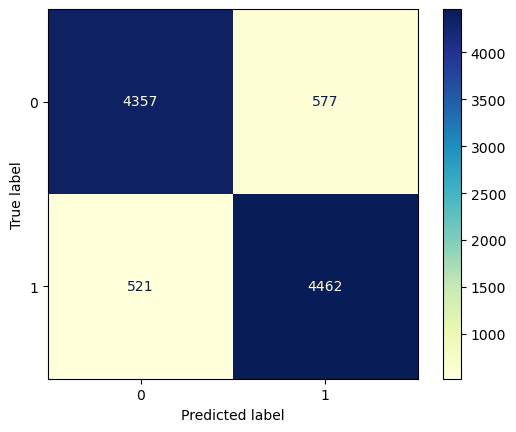

In [ ]:
model = MultinomialNB()
accuracy_scoreMNB = metric_calculation(model)

89.84 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.88      0.90      4934
    Positive       0.88      0.92      0.90      4983

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



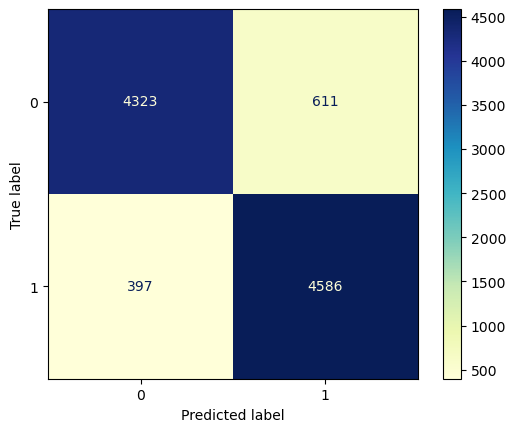

In [ ]:
model = SGDClassifier()
accuracy_scoreSGDC = metric_calculation(model)

91.42 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      4934
    Positive       0.90      0.93      0.92      4983

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917



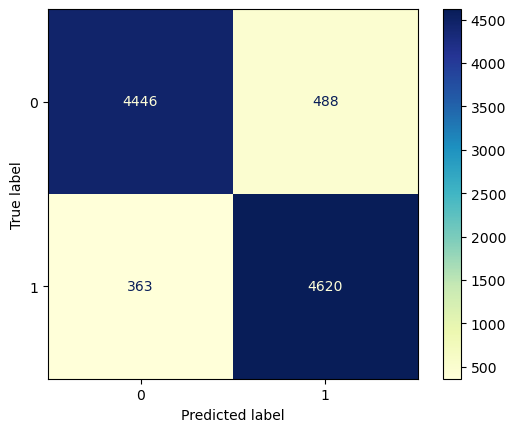

In [ ]:
model = LinearSVC()
accuracy_scoreSVC = metric_calculation(model)

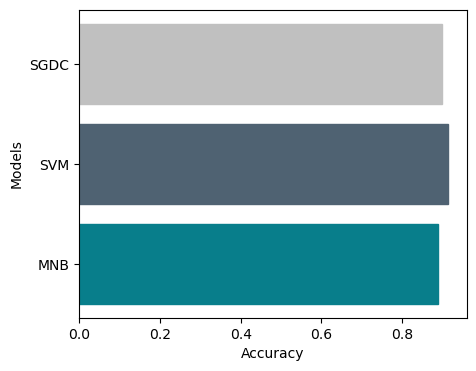

In [ ]:
names = ['MNB', 'SVM', 'SGDC']
acc = [accuracy_scoreMNB, accuracy_scoreSVC, accuracy_scoreSGDC]

plt.figure(figsize=(5,4))
graph = plt.barh(names,acc)
plt.xlabel('Accuracy')
plt.ylabel('Models')
graph[0].set_color('#087E8B')
graph[1].set_color('#4F6272')
graph[2].set_color('silver')

From here we can see that the best model (highest accuracy) is the SVM modeL. Second is SGDC and third MNB, but their values are very similar.

#### Cross validation

Now, I will define function for CV.Three parameters are passed to the function: model, training data, test data. The output is mean accuracy of CV scores.

In [ ]:
def CV(model, X, Y):
    fitted = model.fit(X, Y)
    accuracy = cross_val_score(fitted, X, Y, cv=5,scoring='accuracy')
    print(accuracy.mean())

In [ ]:
CV(LinearSVC(), X_train, y_train)
CV(MultinomialNB(), X_train, y_train)
CV(SGDClassifier(), X_train, y_train)

0.9060884911130719
0.8853145090129837
0.8971133240892474


#### Hyperparametars tuning

Now I will try to find the optimal combination of hyperparameters for the corresponding models using GridSearchCV.

In [ ]:
def grid_search(model, grid):
    gs=GridSearchCV(model, grid, cv=10)
    gs.fit(X_train, y_train)
    return gs

In [ ]:
def print_gs_eval(gs):
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score: {:.4f}\n'.format(gs.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results:', (gs.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\nEstimator that was chosen by the search:', (gs.best_estimator_))

In [ ]:
grid={'C': [0.1,1, 10, 100],
      "penalty":['l1', 'l2', 'elasticnet']}
model=LinearSVC()
gs=grid_search(model, grid)

In [ ]:
print_gs_eval(gs)

GridSearch CV best score: 0.9083

Parameters that give the best results: {'C': 1, 'penalty': 'l2'}

Estimator that was chosen by the search: LinearSVC(C=1)


In [ ]:
grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
      'fit_prior': [True, False]}
model=MultinomialNB()
gs=grid_search(model, grid)

In [ ]:
print_gs_eval(gs)

GridSearch CV best score: 0.8894

Parameters that give the best results: {'alpha': 0.1, 'fit_prior': False}

Estimator that was chosen by the search: MultinomialNB(alpha=0.1, fit_prior=False)


In [ ]:
grid={"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
      "penalty":['l1', 'l2', 'elasticnet']}
model=SGDClassifier()
gs=grid_search(model, grid)

In [ ]:
print_gs_eval(gs)

GridSearch CV best score: 0.8966

Parameters that give the best results: {'alpha': 0.0001, 'penalty': 'l2'}

Estimator that was chosen by the search: SGDClassifier()


### Metrics calculation

Using the optimal parameters that I received previously, I will calculate the accuracy again for each model and see which model is the best.

In [ ]:
models = {
    LinearSVC(C=1): 'SVM',
    MultinomialNB(alpha=0.5, fit_prior=False):"Naive Bayes",
    SGDClassifier(alpha=0.0001, penalty='l2'):"SGDClassifier",
}

for m in models.keys():
    m.fit(X_train, y_train)

for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",model.score(X_test, y_test)*100,"%")

Accuracy Score for SVM is :  91.41877583946759 %
Accuracy Score for Naive Bayes is :  89.14994453967934 %
Accuracy Score for SGDClassifier is :  89.77513360895432 %


As we can see, a bit higher accuracy has SVM model. I will check some other metrics.

In [ ]:
for model,name in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}")
    print("----------------------------------------------------------")
    print(classification_report(y_test,y_pred))
    print("----------------------------------------------------------")

Classification Report for SVM
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4934
           1       0.90      0.93      0.92      4983

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917

----------------------------------------------------------
Classification Report for Naive Bayes
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4934
           1       0.89      0.90      0.89      4983

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

----------------------------------------------------------
Classification Report for SGDClassifier
--

In most cases, the SVM model has better metric values. Let's see ROC curve for both of models.

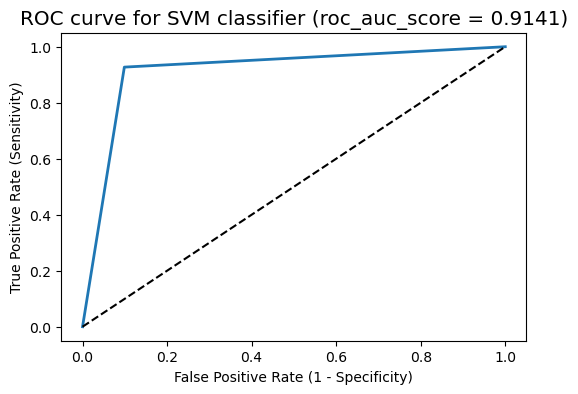

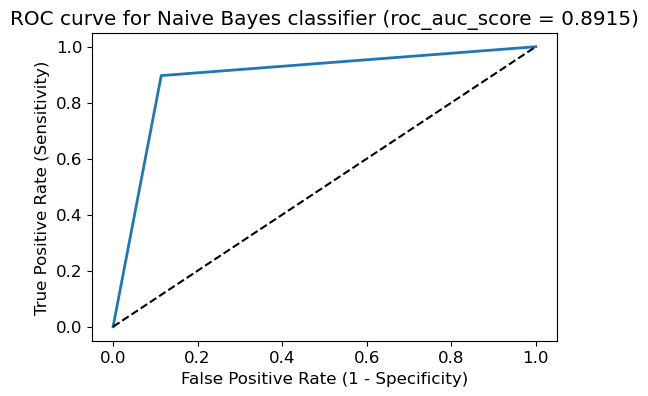

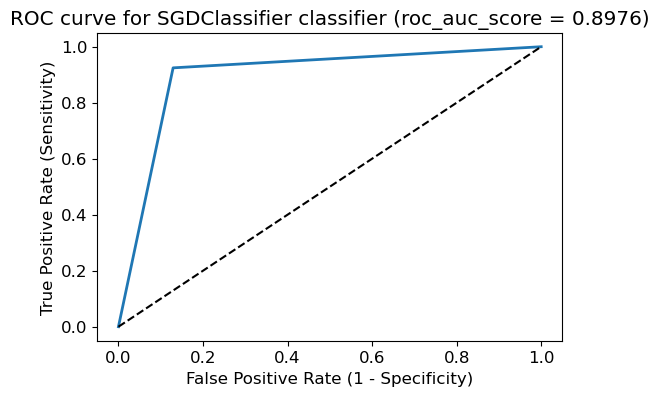

In [ ]:
for model, name in models.items():
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve for {name} classifier (roc_auc_score = {round(metrics.roc_auc_score(y_test, y_pred), 4)})')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    print(" ")

From the graph, I can conclude that roc auc scores for all three models are very similar. The best model is SVM, while the worst is MNB.

#### Check for overfitting and underfitting

In [ ]:
for model,name in models.items():
    y_pred = model.predict(X_train)
    print(f"Training set score for {name}")
    print(model.score(X_train, y_train))
    print(" ")
    print(f"Test set score for {name}")
    print(model.score(X_test, y_test))
    print("----------------------------------------------------------")
    print(" ")

Training set score for SVM
0.9997226774234211
 
Test set score for SVM
0.9141877583946758
----------------------------------------------------------
 
Training set score for Naive Bayes
0.9747384343879995
 
Test set score for Naive Bayes
0.8914994453967934
----------------------------------------------------------
 
Training set score for SGDClassifier
0.9436278835245179
 
Test set score for SGDClassifier
0.8977513360895432
----------------------------------------------------------
 


When I compare the values for training and test data, they do not deviate much from each other, so there is no question of large overfitting and underfitting (it is closer to overfitting, because the accuracy for the training data is higher than the accuracy for the test data for each model).